## seq2seq practice
### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [66]:
start_token = " "

def read_names(path_to_file):
    global start_token
    
    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        names = [start_token + line for line in names]
        return names

In [67]:
try:
    names = read_names('names.txt')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/names_dataset/names -nc -O names
    names = read_names('./names')

In [68]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


In [69]:
for x in list(map(len, names))[::1000]:
    print(x)

8
9
6
8
8
6
9
6


max length = 16


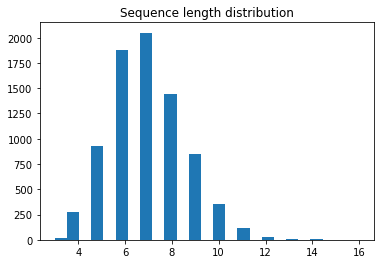

In [70]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [71]:
set(names[0])

{' ', 'A', 'a', 'b', 'e', 'g', 'l'}

In [72]:
set(names[1])

{' ', 'A', 'a', 'b', 'g', 'i', 'l'}

In [73]:
set() | set(names[1])

{' ', 'A', 'a', 'b', 'g', 'i', 'l'}

In [74]:
tokens = set()

for name in names:
    tokens = (tokens | set(name))

In [75]:
len(tokens)

55

In [76]:
tokens = set()

for name in names:
    tokens.update(set(name))

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [77]:
token_values = list(map(ord, tokens))

In [78]:
token_to_id = {token:idx for idx, token in enumerate(tokens)}

In [79]:
token_to_id

{' ': 36,
 "'": 37,
 '-': 23,
 'A': 5,
 'B': 11,
 'C': 51,
 'D': 16,
 'E': 45,
 'F': 13,
 'G': 29,
 'H': 38,
 'I': 41,
 'J': 44,
 'K': 54,
 'L': 4,
 'M': 19,
 'N': 26,
 'O': 53,
 'P': 14,
 'Q': 22,
 'R': 7,
 'S': 15,
 'T': 33,
 'U': 50,
 'V': 21,
 'W': 0,
 'X': 8,
 'Y': 10,
 'Z': 48,
 'a': 24,
 'b': 40,
 'c': 6,
 'd': 52,
 'e': 1,
 'f': 32,
 'g': 34,
 'h': 39,
 'i': 28,
 'j': 43,
 'k': 25,
 'l': 46,
 'm': 9,
 'n': 17,
 'o': 12,
 'p': 3,
 'q': 31,
 'r': 47,
 's': 2,
 't': 30,
 'u': 27,
 'v': 18,
 'w': 20,
 'x': 35,
 'y': 49,
 'z': 42}

In [80]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Converting to matrix:
- For a given name, convert each character in name to its id. This gives a list of number.
- Generate a matrix of dimensions $m\times n$ where $m = \text{len(names)}$ and $n = \text{max(len(names))}$.

In [81]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [82]:
names[:2]

[' Abagael', ' Abagail']

In [83]:
token_to_id[' ']

36

In [84]:
a = 5 or 6

In [85]:
a

5

In [86]:
6 or 5

6

In [87]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[36  5 40 24 34 24  1 46 36]
 [36 29 46 12 47 49 36 36 36]
 [36 14 47 28  2  2 28  1 36]
 [36 29 28 12 18 24 17 17  1]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="https://github.com/girafe-ai/ml-mipt/blob/basic_f20/week0_10_RNN_and_Language_models/rnn.png?raw=1" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id $x_t$ to a vector.
* An output layer that predicts probabilities of next phoneme

In [88]:
len(tokens)

55

In [89]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [90]:
emb_test = nn.Embedding(55, 16)

In [91]:
example_batch = torch.from_numpy(to_matrix(names[::2000])).type(torch.LongTensor)

In [92]:
names[::2000]

[' Abagael', ' Glory', ' Prissie', ' Giovanne']

In [93]:
example_batch

tensor([[36,  5, 40, 24, 34, 24,  1, 46, 36],
        [36, 29, 46, 12, 47, 49, 36, 36, 36],
        [36, 14, 47, 28,  2,  2, 28,  1, 36],
        [36, 29, 28, 12, 18, 24, 17, 17,  1]])

In [94]:
example_batch.shape

torch.Size([4, 9])

In [95]:
emb_test(example_batch).shape

torch.Size([4, 9, 16])

In [96]:
emb_test(example_batch)[0]

tensor([[-1.7068,  1.3573,  0.2379,  0.3142, -0.6745,  1.4368,  0.0734,  0.0252,
          0.3874, -0.3137, -0.5973,  0.6109,  0.2696,  1.0783,  0.6352,  0.4393],
        [ 0.0877,  1.9207, -1.8638, -0.6919, -0.5646, -0.8248, -0.1265,  0.8627,
          0.0721, -0.3290, -0.0810,  0.2013, -0.6295,  0.1990, -0.7842, -1.6983],
        [ 0.3265,  0.4531, -1.5284,  0.2923,  0.3217, -1.4250,  0.9495,  0.3830,
         -1.0423, -0.5986,  2.4670,  1.4030,  0.0603, -2.1798, -0.0672,  0.5265],
        [-0.0848, -1.0753, -1.4100, -0.9616, -0.7059, -0.0265, -0.2403,  0.9818,
          0.4726,  1.1465, -0.7368, -1.8379, -0.8011, -1.6636, -0.5127,  0.3304],
        [ 1.5209,  0.4673,  0.9926,  0.7492, -0.7121, -0.4425, -1.1537, -0.7161,
         -1.0161,  1.3275,  0.2780, -0.2651,  0.0966, -0.3926, -0.9665,  0.7608],
        [-0.0848, -1.0753, -1.4100, -0.9616, -0.7059, -0.0265, -0.2403,  0.9818,
          0.4726,  1.1465, -0.7368, -1.8379, -0.8011, -1.6636, -0.5127,  0.3304],
        [-0.6657, -0.8

In [97]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        #n_to_pick, #one will be embedded as a vector of size embedding_size
        # we have to do this for each token, so the code below generates a embedding
        # matrix of size num_tokens x the embedding_size that we chose.
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        
        # Because of concatenation n_in = rnn_num_units + embedding_size
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens) #n_in, n_out
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # x is of size (batches,)
        # along axis=0 is the integer representing the given character of the given instance
        # x_emb is of size (batches, embedding_size)
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)# YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)# YOUR CODE HERE
        
        h_next = torch.tanh(h_next)# YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [98]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()# YOUR CODE HERE

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [99]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    # we have to process each word, character by character
    # but we can (and have to) process all the words at at time, character by character.
    # by taking the first character on each and feeding it to the network.
    # That's what we do below.
    for x_t in batch_ix.transpose(0,1):
        # When we call model(...), we are actually calling model.__call__(...). 
        # The __call__ method on nn.Module eventually calls forward along with 
        # taking care of tracing and hooks.
        # So char_rnn(x_t, hid_state) is the same as char_rnn.forward(x_t, hid_state)
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [100]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

In [101]:
batch_ix[0].shape

torch.Size([8])

In [102]:
batch_ix

tensor([[36,  5, 40, 24, 34, 24,  1, 46],
        [36,  5, 40, 24, 34, 24, 28, 46],
        [36,  5, 40, 40,  1, 36, 36, 36],
        [36,  5, 40, 40,  1, 49, 36, 36],
        [36,  5, 40, 40, 28, 36, 36, 36]])

In [103]:
names[:5]

[' Abagael', ' Abagail', ' Abbe', ' Abbey', ' Abbi']

In [104]:
emb_tr = None
for x in batch_ix.transpose(0, 1):
    print(x)
    emb_tr = emb_test(x)

tensor([36, 36, 36, 36, 36])
tensor([5, 5, 5, 5, 5])
tensor([40, 40, 40, 40, 40])
tensor([24, 24, 40, 40, 40])
tensor([34, 34,  1,  1, 28])
tensor([24, 24, 36, 49, 36])
tensor([ 1, 28, 36, 36, 36])
tensor([46, 46, 36, 36, 36])


In [105]:
emb_tr.shape

torch.Size([5, 16])

In [106]:
emb_tr[0]

tensor([ 0.2609,  0.3566,  0.2002,  0.7255,  0.3428, -1.7760,  0.0289, -0.4786,
        -0.8673, -1.1133, -0.6735, -0.5338,  0.4880, -1.2287, -0.8417,  0.6055],
       grad_fn=<SelectBackward>)

In [107]:
emb_tr

tensor([[ 0.2609,  0.3566,  0.2002,  0.7255,  0.3428, -1.7760,  0.0289, -0.4786,
         -0.8673, -1.1133, -0.6735, -0.5338,  0.4880, -1.2287, -0.8417,  0.6055],
        [ 0.2609,  0.3566,  0.2002,  0.7255,  0.3428, -1.7760,  0.0289, -0.4786,
         -0.8673, -1.1133, -0.6735, -0.5338,  0.4880, -1.2287, -0.8417,  0.6055],
        [-1.7068,  1.3573,  0.2379,  0.3142, -0.6745,  1.4368,  0.0734,  0.0252,
          0.3874, -0.3137, -0.5973,  0.6109,  0.2696,  1.0783,  0.6352,  0.4393],
        [-1.7068,  1.3573,  0.2379,  0.3142, -0.6745,  1.4368,  0.0734,  0.0252,
          0.3874, -0.3137, -0.5973,  0.6109,  0.2696,  1.0783,  0.6352,  0.4393],
        [-1.7068,  1.3573,  0.2379,  0.3142, -0.6745,  1.4368,  0.0734,  0.0252,
          0.3874, -0.3137, -0.5973,  0.6109,  0.2696,  1.0783,  0.6352,  0.4393]],
       grad_fn=<EmbeddingBackward>)

In [108]:
batch_ix.shape

torch.Size([5, 8])

In [109]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [110]:
logp_seq.shape

torch.Size([5, 8, 55])

In [111]:
logp_seq[0].shape

torch.Size([8, 55])

In [112]:
logp_seq[:, :-1][0].shape

torch.Size([7, 55])

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [113]:
batch_ix

tensor([[36,  5, 40, 24, 34, 24,  1, 46],
        [36,  5, 40, 24, 34, 24, 28, 46],
        [36,  5, 40, 40,  1, 36, 36, 36],
        [36,  5, 40, 40,  1, 49, 36, 36],
        [36,  5, 40, 40, 28, 36, 36, 36]])

In [114]:
batch_ix[:, 1:] 

tensor([[ 5, 40, 24, 34, 24,  1, 46],
        [ 5, 40, 24, 34, 24, 28, 46],
        [ 5, 40, 40,  1, 36, 36, 36],
        [ 5, 40, 40,  1, 49, 36, 36],
        [ 5, 40, 40, 28, 36, 36, 36]])

**<font color=blue>Note</font>**

Cross Entropy:

$$L_{\log}(Y, P) = -\log \operatorname{Pr}(Y|P) = - \frac{1}{N} \sum_{i=0}^{N-1} \sum_{k=0}^{K-1} y_{i,k} \log p_{i,k}$$

Where:

- $p_{i,k}$  is the probability of the $i$-th sample being of the $k$-th class. In our context $p_{i,k}$ is the probability that the next element is the $k$-th character.
- $y_{i,k} = 1$ if the real label (character) is $k$ and $0$ otherwise.

Below:
- We skip the first element (character) from the (`batch_ix[:, 1:]`) since there is no $p_{i,k}$ to pair it against. There is no probability coming before the first element telling us that the first element will be `batch_ix[:, 0]`.
- We skip the last probability (`logp_seq[:, :-1]`), since there is no $y_{i,k}$ to pair it against.

In [115]:
predictions_logp = logp_seq[:, :-1] # we skip the predictions for the last character
actual_next_tokens = batch_ix[:, 1:] # we skip the first character. Pytorch can work with a 
# non one-hot representation of the ground truth.

# .contiguous() method checks that tensor is stored in the memory correctly to 
# get its view of desired shape.

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

In [116]:
predictions_logp.shape

torch.Size([5, 7, 55])

In [117]:
predictions_logp.contiguous().view(-1, num_tokens).shape

torch.Size([35, 55])

In [118]:
actual_next_tokens.shape

torch.Size([5, 7])

In [119]:
actual_next_tokens.contiguous().view(-1).shape

torch.Size([35])

In [120]:
loss.backward()

In [121]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

## The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [122]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [123]:
sample(names, 32)

[' Monique',
 ' Dede',
 ' Shani',
 ' Delila',
 ' Aime',
 ' Ardis',
 ' Salvador',
 ' Sidonia',
 ' Kamilah',
 ' Guy',
 ' Quinn',
 ' Devondra',
 ' Orly',
 ' Brynn',
 ' Salvidor',
 ' Charlotta',
 ' Catrina',
 ' Rafa',
 ' Kraig',
 ' Mitra',
 ' Howard',
 ' Annalee',
 ' Rene',
 ' Hailey',
 ' Manny',
 ' Dulcinea',
 ' Florinda',
 ' Hillel',
 ' Estrellita',
 ' Chrysa',
 ' Wini',
 ' Krysta']

In [124]:
example_batch

tensor([[36,  5, 40, 24, 34, 24,  1, 46, 36],
        [36, 29, 46, 12, 47, 49, 36, 36, 36],
        [36, 14, 47, 28,  2,  2, 28,  1, 36],
        [36, 29, 28, 12, 18, 24, 17, 17,  1]])

In [125]:
sample(list(example_batch), 2)

[tensor([36, 29, 28, 12, 18, 24, 17, 17,  1]),
 tensor([36, 29, 46, 12, 47, 49, 36, 36, 36])]

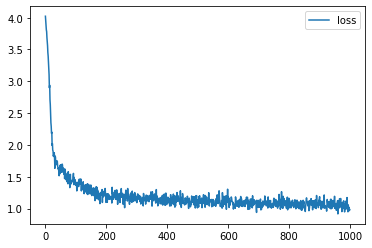

In [126]:
MAX_LENGTH = 16

for i in range(1000):
    
    opt.zero_grad()
    
    # The batch is formed at random
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:] # YOUR CODE HERE

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))# YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [127]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [128]:
s = [54, 232, 12]
s = torch.tensor([s], dtype=torch.int64)

In [129]:
for i in range(3 - 1):
        print(s[:, i])

tensor([54])
tensor([232])


In [131]:
tokens

['W',
 'e',
 's',
 'p',
 'L',
 'A',
 'c',
 'R',
 'X',
 'm',
 'Y',
 'B',
 'o',
 'F',
 'P',
 'S',
 'D',
 'n',
 'v',
 'M',
 'w',
 'V',
 'Q',
 '-',
 'a',
 'k',
 'N',
 'u',
 'i',
 'G',
 't',
 'q',
 'f',
 'T',
 'g',
 'x',
 ' ',
 "'",
 'H',
 'h',
 'b',
 'I',
 'z',
 'j',
 'J',
 'E',
 'l',
 'r',
 'Z',
 'y',
 'U',
 'C',
 'd',
 'O',
 'K']

In [130]:
generate_sample(char_rnn)

' Ansa           '

In [114]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Rooha          
 Walia          
 Forla          
 Viomaden       
 VZenterl       
 Anrsy          
 Anbindle       
 Lis            
 Rjothar        
 Ewssiie        


In [130]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' adasdada'))

 adasdadan      
 adasdada       
 adasdada       
 adasdada       
 adasdada       
 adasdada       
 adasdadan      
 adasdada       
 adasdada       
 adasdaday      


### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [132]:
num_tokens

55

In [134]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [135]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [137]:
len(names)

7944

In [136]:
batch_ix.shape

torch.Size([32, 16])

In [134]:
logp_seq = model(batch_ix)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

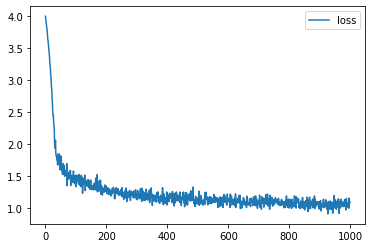

In [135]:
MAX_LENGTH = 16

for i in range(1000):
    
    opt.zero_grad()
    
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    
    # YOUR CODE HERE
    
    # train with backprop

    # YOUR CODE HERE
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:] # YOUR CODE HERE

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))# YOUR CODE HERE
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### To sum up:
- PyTorch is convenient both for prototyping and production
- There are a lot of pre-implemented methods/layers/activations out of the box
- It's much easier (*really easier*) to use PyTorch than TensorFlow on entry level. 
- Neural networks are not *black boxes*, they are pretty nice and easy to use (almost always).

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__